In [29]:
import numpy as np
import numba
import matplotlib.pyplot as plt

@numba.njit 
def simulate_polulation_agents(Bstate, Pstate, Istate, LORstate, time_step, record_time_step, final_time,  bacteria, phage,infected,bacteriaever, carrying_capacity, \
                               growth_rate, lysis_rate, burst_rate, eclipse, growth_timer, lysis_timer, eta, lysis_inhibition=False, lysis_inhibition_timer=5, \
                               lysis_from_without=False, lysis_from_without_phage=10, lo_resistance=False, lo_resistance_time=5, li_collapse=False, li_collapse_phage=100):
    print('started')
    """
    Simulates a population dynamics with individulal bacteria has growth timer and lysis timer. 
    Simulate V ml. The number of phages (integer)

    Parameters:
    - time_step: The time step for evaluating the dynamics.
    -record_time_step: The time step for recording the dynamics.
    - final_time: The final time to simulate.
    - bacteria: The initial number of bacteria.
    - infected: The initial number of infected bacteria.
    - phage: The initial number of phage.
    - carrying_capacity: The carrying capacity of the environment. 
    system volume is calulcated from this assuming 1ml has carrying capacity of 10^9 cells. 
    - growth_rate: The growth rate of the bacteria.
    - lysis_rate: 1/The latency time of the phage production.
    - burst_rate The burst rate of the phage.
    - ecliplse: The ecliplse time of the phage.
    - growth_timer: Number of the growth timer of the bacteria.
    - lysis_timer: Number of the lysis timer of upon infection.
    - eta: The adsorption rate of the phage.
    - lysis_inhibition: Whether the lysis inhibition is present. Default is False.
    
    Returns:
    - time: A list of times.
    - Btimeseries: A list of the number of bacteria at each record time step.
    - Itimeseries: A list of the number of infected bacteria at each record time step.
    - Ptimeseries: A list of the number of phage at each record time step.
    """
    
    volume=carrying_capacity/1e9 # volume in ml

    timenow = 0
    nrecord=int(final_time/record_time_step)
    time = np.zeros(nrecord)
    Btimeseries = np.zeros(nrecord)
    Itimeseries = np.zeros(nrecord)
    Ptimeseries = np.zeros(nrecord)
    irecord=0
    time[irecord]=timenow
    Btimeseries[irecord]=bacteria
    Itimeseries[irecord]=infected
    Ptimeseries[irecord]=phage
    grate= growth_rate*growth_timer
    lrate=lysis_rate*lysis_timer
    print(volume)
    
    
    while timenow < final_time: 
        phagegone=0
        phagenew=0
        for i in range(bacteriaever):
            if(Bstate[i]>0):
                phageinfect=np.random.poisson(eta*phage/volume*time_step)
                if(phageinfect>0):
                    phagegone+=phageinfect
                    Istate[i]+=phageinfect
                    if Bstate[i]<=growth_timer:
                        infected+=1
                        Bstate[i]=growth_timer+1
                    if not LORstate[i] and lysis_from_without :
                        if(Istate[i]>lysis_from_without_phage):    
                            Bstate[i]=0
                            infected-=1
                            bacteria-=1
                            phagenew+=max(int(burst_rate*(Pstate[i]-eclipse)),0)
                    if LORstate[i] or not lysis_from_without:
                        if lysis_inhibition:
                            Bstate[i]=max(growth_timer+1, Bstate[i]-lysis_inhibition_timer*phageinfect)
                        if li_collapse and Istate[i]>li_collapse_phage:
                            Bstate[i]=0
                            infected-=1
                            bacteria-=1
                            phagenew+=max(int(burst_rate*(Pstate[i]-eclipse)),0) 
                if Bstate[i]<growth_timer: 
                    if(np.random.rand()<grate*time_step):
                        Bstate[i]+=1
                elif Bstate[i]==growth_timer:
                    if(np.random.rand()<grate*time_step):
                        Bstate[i]=1
                        bacteria+=1
                        bacteriaever+=1
                        if(bacteriaever<carrying_capacity):
                            Bstate[bacteriaever-1]=1
                        else:
                            print("Carrying capacity reached")
                            timenow=final_time
                            break
                elif Bstate[i]<growth_timer+lysis_timer:
                    Pstate[i]+=time_step
                    if(lo_resistance):
                        if not LORstate[i] and Pstate[i] > lo_resistance_time:
                        # Code to execute when LORstate[j] is False and Pstate[j] > lo_resistance_time
                            LORstate[i]=True
                    if(np.random.rand()<lrate*time_step):
                        Bstate[i]+=1
                elif Bstate[i]==growth_timer+lysis_timer:
                    if(np.random.rand()<lrate*time_step):
                        Bstate[i]=0
                        infected-=1
                        bacteria-=1
                        phagenew+=max(int(burst_rate*(Pstate[i]-eclipse)),0)
            
        phage=max(phage-phagegone+phagenew,0)
        timenow+=time_step
        if(timenow>time[irecord]+record_time_step):
            irecord+=1
            time[irecord]=timenow
            Btimeseries[irecord]=bacteria
            Itimeseries[irecord]=infected
            Ptimeseries[irecord]=phage
            print(irecord, time[irecord], Btimeseries[irecord], Itimeseries[irecord], Ptimeseries[irecord])
    
                          
    return time, Btimeseries, Itimeseries, Ptimeseries, irecord


In [30]:
#Here we define the system parameters.
#We start with the simulation done in the Julia's thesis of different MSOI
growth_rate = 0 #per minute
lysis_rate = 1/23  #per minute
growth_timer = 10 #max growth timer
lysis_timer = 23 #max lysis timer
eclipse = 15    #eclipse time in minutes
burst_size = 100 #burst size
burst_rate=burst_size/(1/lysis_rate-eclipse)
eta = 5e-9  #adsorption rate per ml/min
lysis_inhibition=True
lysis_inhibition_timer=5
lysis_from_without=False
lysis_from_without_phage=10
lo_resistance=False
lo_resistance_time=5
li_collapse=False
li_collapse_phage=80
time_step=0.001

4967
started
0.001
1 1.0000000000000007 20000.0 10225.0 4491.0
2 2.0000000000000013 20000.0 10426.0 4084.0
3 3.00999999999998 20000.0 10626.0 3654.0
4 4.019999999999959 20000.0 10780.0 3308.0
5 5.029999999999937 20000.0 10937.0 2981.0
6 6.039999999999916 20000.0 11065.0 2698.0
7 7.049999999999894 20000.0 11178.0 2424.0
8 8.059999999999873 20000.0 11274.0 2195.0
9 9.069999999999851 19999.0 11371.0 1968.0
10 10.07999999999983 19996.0 11446.0 1783.0
11 11.089999999999808 19988.0 11505.0 1625.0
12 12.099999999999786 19970.0 11554.0 1444.0
13 13.109999999999765 19933.0 11587.0 1296.0
14 14.119999999999743 19841.0 11547.0 1192.0
started
0.001
1 1.0000000000000007 8021.0 11224.0 453.0
2 2.0000000000000013 7685.0 10958.0 3977.0
3 3.00999999999998 7249.0 10877.0 12584.0
4 4.019999999999959 6686.0 11019.0 29481.0
5 5.029999999999937 6147.0 11790.0 49903.0
6 6.039999999999916 5680.0 12865.0 71112.0
7 7.049999999999894 5287.0 13929.0 90434.0
8 8.059999999999873 5019.0 14702.0 103264.0
9 9.06999999

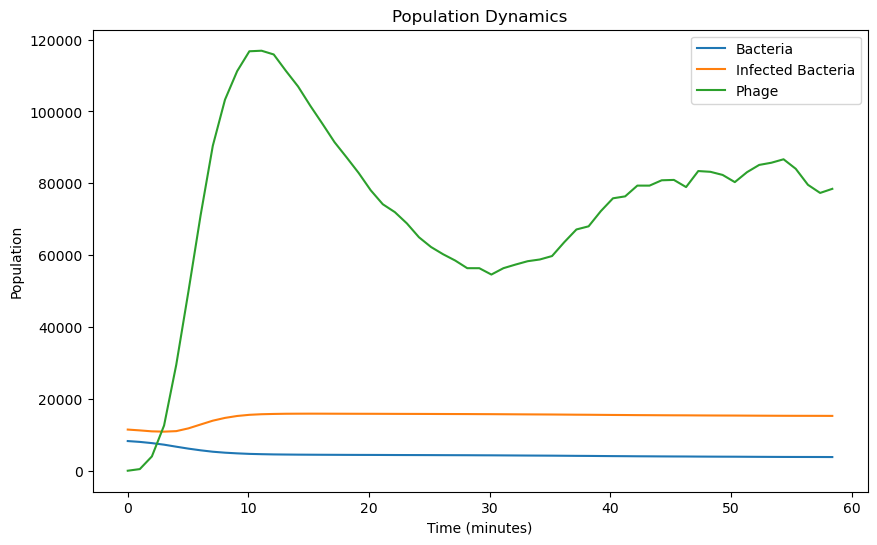

In [31]:
#Now set the initial condition and run the simulation. 
record_time_step = 1 #minutes

factor=0.01
carrying_capacity = int(1e9*factor) #max cells
bacteria = int(2e5) #cells
infected=int(1e5)
si_duration=3 #minutes
msoi=0. #=P_0(1-exp(-eta*B*si_duration))/(eta*B^2)
P0=msoi*(eta*((bacteria+infected)/factor)**2)/(1-np.exp(-eta*float(bacteria+infected)/factor*si_duration))
phage = int(P0*factor) #pfu
si_time=15 #minutes
final_time = si_time #minutes

Bstate = np.zeros(carrying_capacity) # 1 to growth_timer is uninfected, growth_timer+1 to growth_timer+lysis_timer is infected
    # assign a random integer number between 1 and growth_timer to each bacteria
Pstate = np.zeros(carrying_capacity) # recording time spent in infected state, to compute number of produced phages for an infected bacteria, proportional to time spent in infected state (minus ecliplse)
Istate = np.zeros(carrying_capacity) # Count the number of infection in total
LORstate = np.zeros(carrying_capacity, np.bool_) # boolian, True if it is in Lysis from without resistant state
Bstate[:bacteria-infected] = np.random.randint(1, growth_timer+1, size=bacteria-infected)
Bstate[bacteria-infected:bacteria] = growth_timer+1
bacteriaever=bacteria
print(phage)
time, Btimeseries, Itimeseries, Ptimeseries, irecord = simulate_polulation_agents(Bstate, Pstate, Istate, LORstate, time_step,record_time_step, final_time,  \
                                bacteria, phage, infected,bacteriaever, carrying_capacity, \
                               growth_rate, lysis_rate, burst_rate,eclipse, growth_timer, lysis_timer, eta, lysis_inhibition, lysis_inhibition_timer, \
                                   lysis_from_without, lysis_from_without_phage, lo_resistance, lo_resistance_time, li_collapse, li_collapse_phage)

phage=0
mask = (Bstate >= 1) & (Bstate <= growth_timer)
bacteria=np.sum(mask)
mask = (Bstate >= growth_timer+1) 
infected=np.sum(mask)
final_time = 60 #minutes


time2, Btimeseries2, Itimeseries2, Ptimeseries2, irecord2 = simulate_polulation_agents(Bstate, Pstate, Istate, LORstate, time_step,record_time_step, final_time,  \
                                bacteria, phage, infected, bacteriaever, carrying_capacity, \
                               growth_rate, lysis_rate, burst_rate,eclipse, growth_timer, lysis_timer, eta, lysis_inhibition, lysis_inhibition_timer, \
                                   lysis_from_without, lysis_from_without_phage, lo_resistance, lo_resistance_time, li_collapse, li_collapse_phage)



plt.figure(figsize=(10, 6))
plt.plot(time2[:irecord2], Btimeseries2[:irecord2], label='Bacteria')
plt.plot(time2[:irecord2], Itimeseries2[:irecord2], label='Infected Bacteria')
plt.plot(time2[:irecord2], Ptimeseries2[:irecord2], label='Phage')
plt.xlabel('Time (minutes)')
plt.ylabel('Population')
plt.title('Population Dynamics')
plt.legend()
plt.show()

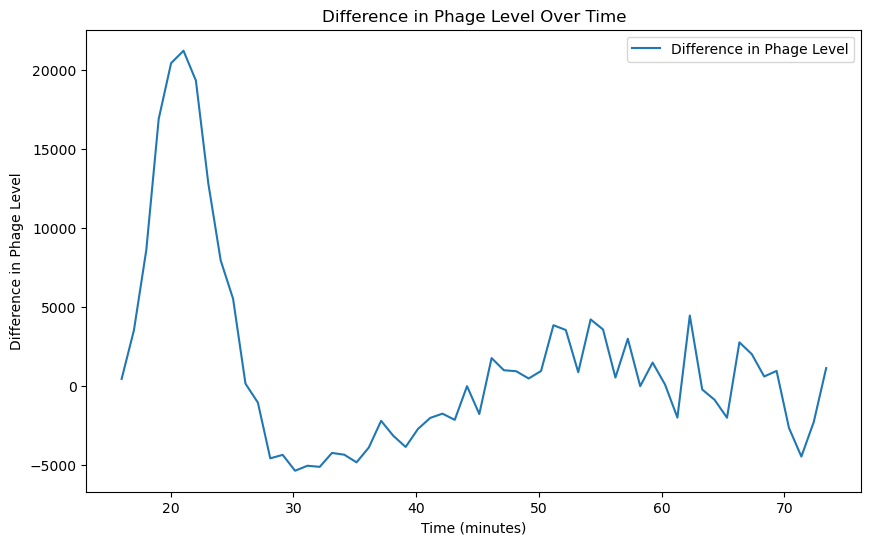

In [32]:
P_diff = np.diff(Ptimeseries2[:irecord2])

# Create a new figure for the difference plot
plt.figure(figsize=(10, 6))

# Plot the difference in Phage levels
plt.plot(time2[1:irecord2]+15, P_diff, label='Difference in Phage Level')

# Label the axes
plt.xlabel('Time (minutes)')
plt.ylabel('Difference in Phage Level')

# Add a title to the plot
plt.title('Difference in Phage Level Over Time')

# Add a legend
plt.legend()

# Display the plot
plt.show()